# Natural Language Processing - Project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, losses
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import re
import string

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Sentiment Analysis on News Headline - Sarcasm Detection

#### 1. Read and explore the data [3 Marks]

In [33]:
#Reading the dataset
SHD = pd.read_json('/content/drive/MyDrive/Python - Collab/15. Module-10_Natural Language Processing/Natural Language Processing - Project/Sarcasm_Headlines_Dataset.json', lines=True)
SHD.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [34]:
#Copying the data to work on it further
shd = SHD.copy()

#Displaying the dataset
shd.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


##### Exploring the data

In [35]:
#Getting the information of data
shd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


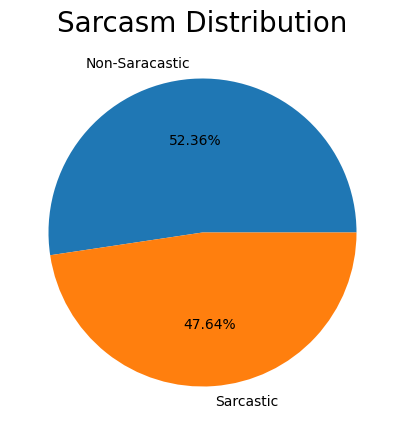

In [36]:
plt.figure(figsize=(5,5))
plt.pie(shd['is_sarcastic'].value_counts(normalize=True), labels=shd['is_sarcastic'].value_counts().index.map({0:'Non-Saracastic', 1:'Sarcastic'}),
        autopct='%.2f%%')
plt.title('Sarcasm Distribution', fontdict={'fontsize':20})
plt.show();

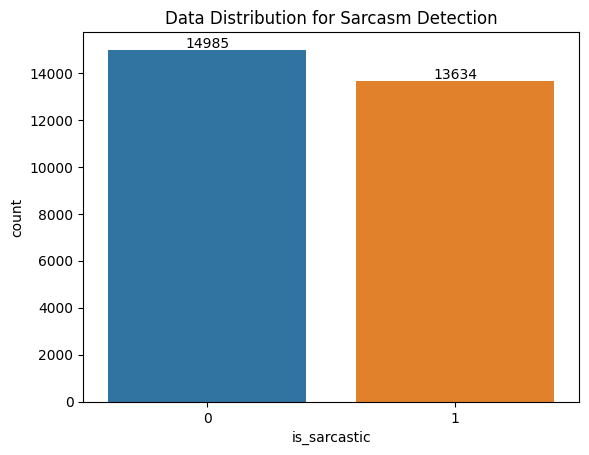

In [37]:
#Checking the distribution of sarcasm/not sarcasm in the dataframe
sns.countplot(data=shd, x='is_sarcastic')
plt.title('Data Distribution for Sarcasm Detection')
for i in range(len(shd['is_sarcastic'].value_counts())):
    plt.text(i, shd['is_sarcastic'].value_counts()[i]+100, shd['is_sarcastic'].value_counts()[i], ha='center')
plt.show();

In [38]:
#Bifurcating the Sarcastic & Non-Sarcastic headline data
sarcastic_hl = shd[shd['is_sarcastic'] == 1]
non_sarcastic_hl = shd[shd['is_sarcastic'] == 0]
print('Dispalying Sarcastic Headline Dataframe')
display(sarcastic_hl)
print('\n')
print('Displaying Non-Sarcastic Headline Dataframe')
display(non_sarcastic_hl)

Dispalying Sarcastic Headline Dataframe


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
...,...,...,...
28612,1,polish rapper under fire for use of the word '...,https://entertainment.theonion.com/polish-rapp...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...




Displaying Non-Sarcastic Headline Dataframe


,is_sarcastic,headline,article_link
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...
...,...,...,...
28607,0,what our grieving family needs from loved ones...,https://www.huffingtonpost.com/entry/what-our-...
28608,0,stephen colbert attempts to list everything tr...,https://www.huffingtonpost.com/entry/stephen-c...
28609,0,bakery owner vows to stop making wedding cakes...,https://www.huffingtonpost.com/entry/jack-phil...
28613,0,how san antonio's dominant defense is fueling ...,https://www.huffingtonpost.com/entry/san-anton...


##### Analysing the Sarcasm data from different websites

In [39]:
#Analysing the Sarcasm data based on website
print('Analysing the Sarcasm data based on website')

#Getting the data of Sarcastic Headlines
sar_hfp = sarcastic_hl[sarcastic_hl['article_link'].str.contains('huffingtonpost.com')]
sar_o = sarcastic_hl[sarcastic_hl['article_link'].str.contains('theonion.com')]

#Getting the data of Non-Sarcastic Headlines
non_sar_hfp = non_sarcastic_hl[non_sarcastic_hl['article_link'].str.contains('huffingtonpost.com')]
non_sar_o = non_sarcastic_hl[non_sarcastic_hl['article_link'].str.contains('theonion.com')]

Sarcasm_Website = pd.DataFrame({'huffingtonpost':[sar_hfp.shape[0], non_sar_hfp.shape[0]], 'theonion':[sar_o.shape[0], non_sar_o.shape[0]]},
                               index = ['Sarcastic', 'Non-Sarcastic'])
display(Sarcasm_Website)

Analysing the Sarcasm data based on website


,huffingtonpost,theonion
Sarcastic,0,13634
Non-Sarcastic,14985,1


##### Generating WordCloud for Sarcastic Headline

There are 904356 words in combination of all Sarcastic Reviews




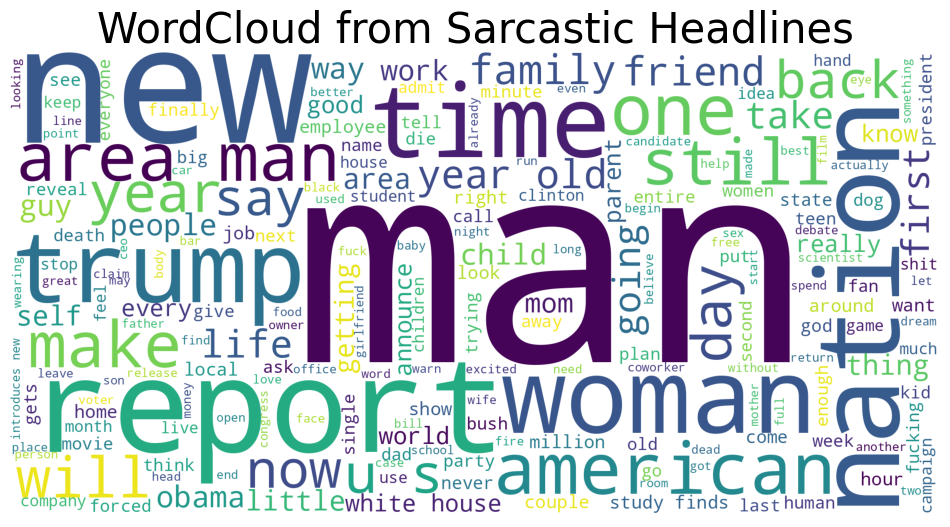

In [40]:
text_s = ' '.join(word for word in sarcastic_hl['headline'])
print('There are {} words in combination of all Sarcastic Reviews'.format(len(text_s)))
print('\n')

sarcastic_wc = WordCloud(stopwords=STOPWORDS, background_color='white', width=2000, height=1000).generate(text_s)
plt.figure(figsize=(12, 12))
plt.imshow(sarcastic_wc)
plt.axis('off')
plt.title('WordCloud from Sarcastic Headlines', fontdict={'fontsize': 30})
plt.show();

##### Generating WordCloud of Non-Sarcastic Headline

There are 907470 words in combination of all Non-Sarcastic Reviews




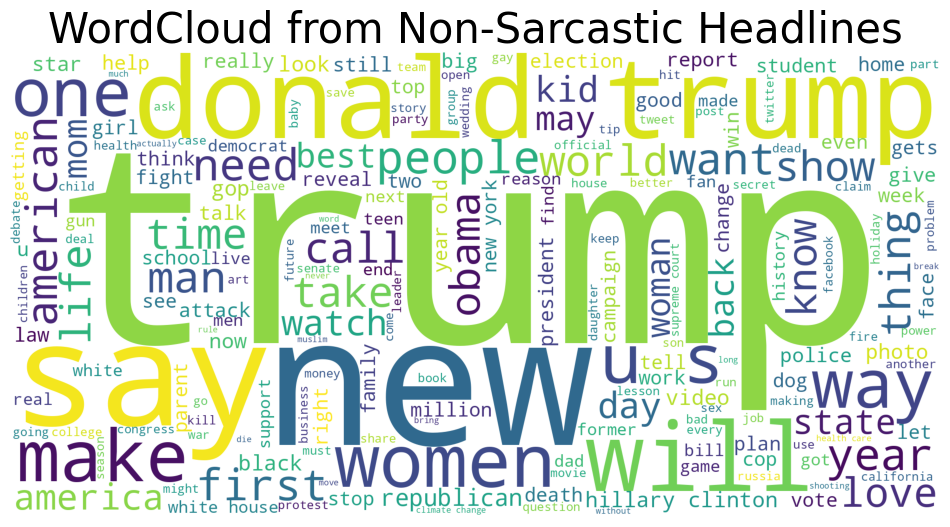

In [41]:
text_ns = ' '.join(word for word in non_sarcastic_hl['headline'])
print('There are {} words in combination of all Non-Sarcastic Reviews'.format(len(text_ns)))
print('\n')

non_sarcastic_wc = WordCloud(stopwords=STOPWORDS, background_color='white', width=2000, height=1000).generate(text_ns)
plt.figure(figsize=(12, 12))
plt.imshow(non_sarcastic_wc)
plt.axis('off')
plt.title('WordCloud from Non-Sarcastic Headlines', fontdict={'fontsize': 30})
plt.show();

#### 2. Retain relevant columns [3 Marks]

- Since the 'article_link' doesnot serve any purpose for sarcasm detection in headline, we may drop the column while retaining 'is_sarcastic' & 'headline' columns

In [42]:
#Dropping 'article_link' column
shd.drop('article_link', axis=1, inplace=True)

#Displaying the dataframe after dropping irrelevant columns
shd.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


#### 3. Get length of each sentence [3 Marks]

In [43]:
#Cleaning the headline colunm of data
final_corpus = []

for i in range(shd.shape[0]):
    #Removing punctuation marks from the sentences
    text = re.sub(r'[^\w\s]', '', shd['headline'][i])

    #lowering the letters
    text = text.lower()

    #Removing space
    text = re.sub(r'\s+', ' ', text)

    #Appending the final corpus
    final_corpus.append(text)

shd['cleaned_headline'] = final_corpus

In [44]:
#Dislaying dataframe after adding cleaned text as a column
shd.head()

,is_sarcastic,headline,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails why congress is falling ...
2,0,eat your veggies: 9 deliciously different recipes,eat your veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close to using word stream...


In [45]:
#Getting the length of each sentence of headline column.
print('Getting the length of each sentence: \n')
shd['sent_length'] = [len(i) for i in shd['cleaned_headline']]

#Stastical detials
print('1. Average length of each sentence in cleaned headline:', round(shd['sent_length'].mean(),2), '\n')
print('2. The length of longest sentence in cleaned headline:', shd['sent_length'].max(), '\n')
print('3. The length of shortest sentence in cleaned headline:', shd['sent_length'].min(), '\n')

Getting the length of each sentence: 

1. Average length of each sentence in cleaned headline: 61.17 

2. The length of longest sentence in cleaned headline: 910 

3. The length of shortest sentence in cleaned headline: 7 



In [46]:
#Getting the length of each sentence based on numebr of words in headline column.
print('Getting the length of each sentence: \n')
shd['num_words'] = [len(i.split(' ')) for i in shd['cleaned_headline']]

#Stastical detials
print('1. Average number of words each sentence in cleaned headline:', int(shd['num_words'].mean()), '\n')
print('2. Maximum number of words present in a sentence in cleaned headline:', shd['num_words'].max(), '\n')
print('3. Minimum number of words present in a sentence in cleaned headline:', shd['num_words'].min(), '\n')
print('4. Standard Deviation for number of words present in each sentence in cleaned headline:', int(shd['num_words'].std()))

Getting the length of each sentence: 

1. Average number of words each sentence in cleaned headline: 10 

2. Maximum number of words present in a sentence in cleaned headline: 151 

3. Minimum number of words present in a sentence in cleaned headline: 2 

4. Standard Deviation for number of words present in each sentence in cleaned headline: 3


#### 4. Define parameters [3 Marks]

In [47]:
#Defining parameters
max_feature = 10000 #(vocab_size)
max_length = 15 #Since avg. number of words present in each sentence is 10, & the standard deviation is 3 max_length of 15 will suffice.
embedding_dim = 300

#### 5. Get indices for words [3 Marks]

In [48]:
#Tokenizing the word in cleaned_headline
tokenizer = Tokenizer(num_words=max_feature)
tokenizer.fit_on_texts(shd['cleaned_headline'])

#Getting the word indices of the words in cleaned_headline
word_indices = tokenizer.word_index
print(word_indices)

{'to': 1, 'of': 2, 'the': 3, 'in': 4, 'for': 5, 'a': 6, 'on': 7, 'and': 8, 'with': 9, 'is': 10, 'new': 11, 'trump': 12, 'man': 13, 'from': 14, 'at': 15, 'about': 16, 'you': 17, 'by': 18, 'after': 19, 'this': 20, 'be': 21, 'out': 22, 'that': 23, 'as': 24, 'it': 25, 'how': 26, 'up': 27, 'not': 28, 'he': 29, 'his': 30, 'are': 31, 'just': 32, 'what': 33, 'your': 34, 'who': 35, 'has': 36, 'all': 37, 'will': 38, 'report': 39, 'us': 40, 'more': 41, 'into': 42, 'one': 43, 'have': 44, 'over': 45, 'why': 46, 'woman': 47, 'area': 48, 'can': 49, 'says': 50, 'day': 51, 'donald': 52, 'time': 53, 'no': 54, 'its': 55, 'like': 56, 'first': 57, 'get': 58, 'her': 59, 'trumps': 60, 'people': 61, 'now': 62, 'house': 63, 'an': 64, 'i': 65, 'off': 66, 'life': 67, 'still': 68, 'white': 69, 'obama': 70, 'make': 71, 'was': 72, 'back': 73, 'than': 74, 'if': 75, 'women': 76, 'down': 77, 'my': 78, 'when': 79, 'we': 80, 'clinton': 81, 'could': 82, 'they': 83, 'years': 84, 'their': 85, 'before': 86, 'world': 87, 'hi

#### 6. Create features and labels [3 Marks]

In [49]:
#Creating features (x) & labels(y)
x = tokenizer.texts_to_sequences(shd['cleaned_headline'])
x = pad_sequences(x, max_length, padding='post', truncating='post')
y = np.asarray(shd['is_sarcastic'])

#Displaying the first feature & label
print('First Feature - First headline:')
print(x[0])
print('\n')
print('First Label of First headline')
print(y[0])
print('\n')

#Printing the shape of Features & Labels
print('Shape of Feature:', x.shape)
print('Shape of Labels:', y.shape)

First Feature - First headline:
[ 336 3105 6322 2319    2  671 1138    0    0    0    0    0    0    0
    0]


First Label of First headline
1


Shape of Feature: (28619, 15)
Shape of Labels: (28619,)


#### 7. Get vocabulary size [3 Marks]

In [50]:
#Getting Vocabulary Size
vocabulary_size = len(word_indices) + 1 #Here 1 is added because the special token <PAD> is not included in the word_indices dictionary
print(vocabulary_size)

29640


#### 8.Create a weight matrix using GloVe embeddings [3 Marks]

In [51]:
#Unzipping the glove.6B.zip file
!unzip '/content/drive/MyDrive/Python - Collab/15. Module-10_Natural Language Processing/glove.6B.zip'

Archive:  /content/drive/MyDrive/Python - Collab/15. Module-10_Natural Language Processing/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [52]:
#Load the GloVe embeddings file into a NumPy array.
embedding_index = {}

embeddings = open(r'/content/glove.6B.300d.txt', encoding='utf8')

for line in tqdm(embeddings):
  #Splitting each line
  values = line.split()
  word = values[0]
  coefs = np.array(values[1:], dtype='float32')
  embedding_index[word] = coefs

embeddings.close()

print('Found %s word vectors' % len(embedding_index))

400000it [00:28, 13977.27it/s]

Found 400000 word vectors


In [53]:
num_words = min(max_feature, vocabulary_size) + 1

#Creating weight matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

for word ,i in word_indices.items():
  if i > max_feature: continue

  embedding_vector = embedding_index.get(word)

  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

#### 9. Define and compile a Bidirectional LSTM model. [3 Marks]

In [54]:
#Splitting the dataset into train & test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

print('Shape of Feature data in Training Set:', x_train.shape)
print('Shape of Feature data in Testing Set:', x_test.shape)

Shape of Feature data in Training Set: (22895, 15)
Shape of Feature data in Testing Set: (5724, 15)


In [55]:
#Building the Model
bilstm = Sequential()
bilstm.add(Embedding(num_words, embedding_dim, weights = [embedding_matrix], input_length=max_length))
bilstm.add(Bidirectional(LSTM(128, return_sequences=True)))
bilstm.add(GlobalMaxPool1D())
bilstm.add(Dense(128, activation='relu'))
bilstm.add(Dense(64, activation='relu'))
bilstm.add(Dense(1, activation='sigmoid'))

#Compiling the Model
bilstm.compile(optimizer=Adam(), loss=losses.binary_crossentropy, metrics=['accuracy'])

In [56]:
#Summary of the model
bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 15, 300)           3000300   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 256)          439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                

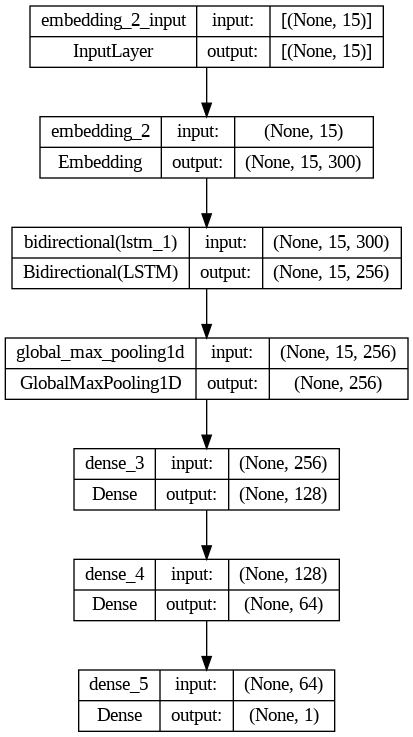

In [57]:
plot_model(bilstm, show_shapes=True)

#### 10. Fit the model and check the validation accuracy [3 Marks]

In [58]:
#Fitting the Model
BILSTM = bilstm.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test), verbose=1)

Epoch 1/50
179/179 [==============================] - 25s 107ms/step - loss: 0.4074 - accuracy: 0.8076 - val_loss: 0.3283 - val_accuracy: 0.8569
Epoch 2/50
179/179 [==============================] - 6s 31ms/step - loss: 0.2237 - accuracy: 0.9080 - val_loss: 0.3050 - val_accuracy: 0.8756
Epoch 3/50
179/179 [==============================] - 4s 22ms/step - loss: 0.1246 - accuracy: 0.9544 - val_loss: 0.3296 - val_accuracy: 0.8763
Epoch 4/50
179/179 [==============================] - 3s 18ms/step - loss: 0.0611 - accuracy: 0.9802 - val_loss: 0.4624 - val_accuracy: 0.8711
Epoch 5/50
179/179 [==============================] - 3s 17ms/step - loss: 0.0308 - accuracy: 0.9904 - val_loss: 0.5202 - val_accuracy: 0.8754
Epoch 6/50
179/179 [==============================] - 3s 14ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.5792 - val_accuracy: 0.8753
Epoch 7/50
179/179 [==============================] - 3s 18ms/step - loss: 0.0102 - accuracy: 0.9966 - val_loss: 0.7040 - val_accuracy: 0.86

In [59]:
#Model Evaluation
print('Evaluating Training Set for BILSTM Model:\n')
train_loss, train_accuracy = bilstm.evaluate(x_train, y_train)
print('Training Loss: {:.4f} and Training Accuracy: {:.4f}'.format(train_loss, train_accuracy))

print('\n')
print('Evaluating Testing Set for BILSTM Model:\n')
test_loss, test_accuracy = bilstm.evaluate(x_test, y_test)
print('Testing Loss: {:.4f} and Testing Accuracy: {:.4f}'.format(test_loss, test_accuracy))

Evaluating Training Set for BILSTM Model:

716/716 [==============================] - 3s 4ms/step - loss: 3.0525e-04 - accuracy: 0.9999
Training Loss: 0.0003 and Training Accuracy: 0.9999


Evaluating Testing Set for BILSTM Model:

179/179 [==============================] - 1s 4ms/step - loss: 1.0789 - accuracy: 0.8688
Testing Loss: 1.0789 and Testing Accuracy: 0.8688


179/179 [==============================] - 1s 3ms/step
-------------------- Confusion Matrix --------------------


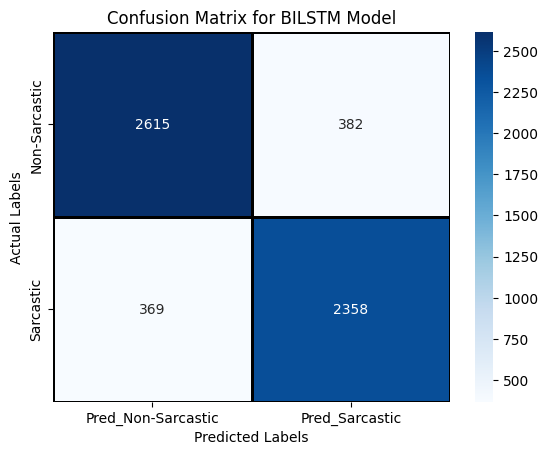




-------------------- Classification Report for BILSTM Model --------------------
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2997
           1       0.86      0.86      0.86      2727

    accuracy                           0.87      5724
   macro avg       0.87      0.87      0.87      5724
weighted avg       0.87      0.87      0.87      5724



In [60]:
#Predicting the values
bilstm_pred = (bilstm.predict(x_test) > 0.5).astype('int32')

#Printing Confusion Matrix using Heatmap
print('-'*20, 'Confusion Matrix', '-'*20)
bilstm_cm = confusion_matrix(y_test, bilstm_pred)
sns.heatmap(bilstm_cm, cmap='Blues', annot=True, fmt='g', linecolor='black', linewidth=1, xticklabels=['Pred_Non-Sarcastic', 'Pred_Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for BILSTM Model')
plt.show();

print('\n\n')
print('-'*20, 'Classification Report for BILSTM Model', '-'*20)
bilstm_cr = classification_report(y_test, bilstm_pred)
print(bilstm_cr)

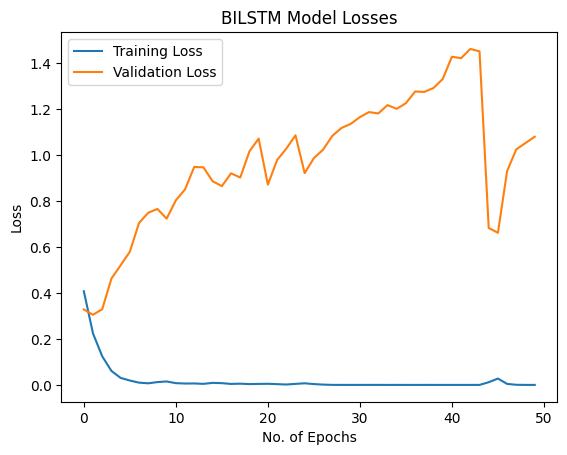

In [61]:
#Plotting Training Loss & Validation Loss vs Number of Epochs
plt.plot(BILSTM.history['loss'])
plt.plot(BILSTM.history['val_loss'])
plt.title('BILSTM Model Losses')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='best')
plt.show();

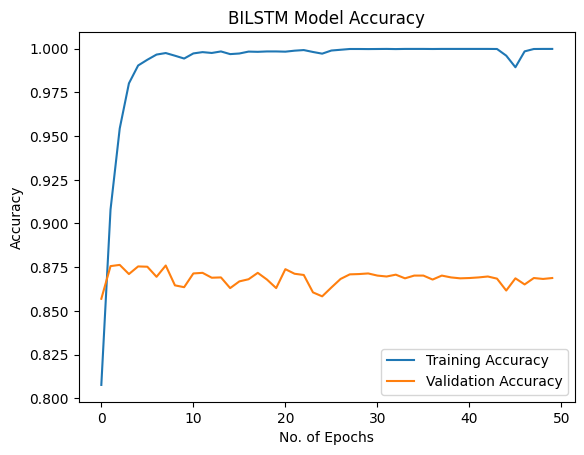

In [62]:
#Plotting Training Accuracy & Validation Accuracy vs Number of Epochs
plt.plot(BILSTM.history['accuracy'])
plt.plot(BILSTM.history['val_accuracy'])
plt.title('BILSTM Model Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.show();

### Observations:
- The dataset contains 3 attributes: 2 Features & 1 Label.
- The labels (Sarcastic & Non-Sarcastic) are distributed ~ 48% (Sarcastic) & ~52% (Non-Sarcastic) which seems that it is almost balanced dataset.
- Further we observe that the website **"huffingpost"** has 0 sarcastic headlines and all the headlines are Non-Sarcastic, while the website **"theonion"** has only 1 Non-Sarcastic headline while all other headlines are Sarcastic.
- From this once individual may develop a prespective that particular webiste may hold Sarcastic or Non-Sarcastic data only.
- Further can see the type of words used in Sarcastic & Non-Sarcastic headlines in Wordcloud.
- Later on we dropped the 'article_link' attribute as it is insigficient in determining Sarcastic Headline. (One should not develop a prespective for website to provide a particular type of headline).
- We then processed the data by removing punctuation marks, lowering the letter & removing the extra spaces in the headlines, which is beneficial for our model to learn.
- Since the dataset is non-sequential, we need to convert it into sequencial form in order to train a model.
- We have trained Bidirectional LSTM model which has Training accuracy of ~ 99% while only ~ 87% of Test accuracy which suggest that the model is overfit.